In [1]:
%matplotlib inline 
import requests
import pandas as pd
import json
import pickle
import geopandas as gpd
import matplotlib 
import matplotlib.pyplot as plt
from pyquadkey2 import quadkey
from pyquadkey2.quadkey import QuadKey
from pyquadkey2.quadkey import TileAnchor, QuadKey
from shapely.geometry import Point, LineString, Polygon

Requirments: 

- #pip install pyquadkey2

Resources: 
- Description of Quadkeys https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system 
- Library to work with lat lon and QuadKeys https://github.com/CartoDB/python-quadkey 
- Methodlogy paper https://arxiv.org/ftp/arxiv/papers/2104/2104.07761.pdf 
- OSM page for getting the tiles based on coordinate system https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Lon..2Flat._to_tile_numbers_2
- Python library documentation 
https://docs.muetsch.io/pyquadkey2/ 
- The RWI data is available here: https://data.humdata.org/dataset/relative-wealth-index choose the data that includes the Quadkeys. the data will be downloaded as bulk and includes all csv's for the RWI data.


QuadKeys: 
- the length of the quad key is the level of detail it refers to (longest = more granular level) 
- parent -child relationship: tile 2 is the perant of tile 20 

Our data is in zoom level 14, which is 9.555 meters/pixel resolution 

Workflow: 

- Use FB data to populate the list of Quadkeys (QK)
- Use the pyquadkey2 library to get four cooordinates for each QK: SW, NE, SE, NW 
- Use each for cooridnate set to create the tile data 
- Tranform into polygons, merge back with the FB data: this will result in a polygon type shapefile, each row represents one QK for a point 
- Export data 


* 2.4Km2 is aproximatly 5.76 km2 area 
* looking into the QuadKeys it seems as though the nearest tile size is 5982842.156102487 Square meteres
* this measurment is closest to tiles sized 2.447 KM (length and width)
* Coordinate system is WGS 84 datum. 
* FB data uses level 14 data, each Quadkey is reprsented by 14 digits 

## Approach: 
Use data from FB which already includes QuadKeys




# Plug-in FB data + AOI 

In [2]:
# AOI Kolkata
aoi = gpd.read_file('admin/AOI_Kolkata_Metropolitan_Area_4326.shp')

In [3]:
# fb data for India 
FB_QKdata = pd.read_csv('data/IND_PAK_relative_wealth_index.csv')
FB_QKdata.head()

,quadkey,latitude,longitude,rwi,error
0,12310322233000,32.091882,73.663330,0.101,0.490
1,12310320211300,33.642062,73.751221,-0.354,0.435
2,12303300330332,25.967922,63.072510,-0.251,0.396
3,12312212002233,25.492868,70.389404,-0.160,0.400
4,12312203010200,25.710836,69.268799,-0.690,0.421


In [4]:
# change quadkey format to str
FB_QKdata["quadkey1"] = FB_QKdata["quadkey"].astype('str')

In [5]:
FB_QKdata.dtypes

quadkey        int64
latitude     float64
longitude    float64
rwi          float64
error        float64
quadkey1      object
dtype: object

In [6]:
# fill 13 digit quadkeys with 0 before the QK
FB_QKdata['quadkey1'] = FB_QKdata['quadkey1'].apply(lambda x: x.zfill(14))

In [7]:
# take column with quadkeys and transform it to list and then to QuadKey object
fb_qk = FB_QKdata["quadkey1"].tolist()
FB_QK = [QuadKey(i) for i in fb_qk]

In [8]:
# locate the four corners of QuadKey tiles
SW = []
NE = []
SE = []
NW = []

for i in FB_QK:
    #south west point
    sw = i.to_geo(anchor=TileAnchor.ANCHOR_SW)
    SW.append(sw) 
    #north west point
    ne = i.to_geo(anchor=TileAnchor.ANCHOR_NE)
    NE.append(ne) 
    #south east point 
    se = i.to_geo(anchor=TileAnchor.ANCHOR_SE)
    SE.append(se)
    #north west point 
    nw = i.to_geo(anchor=TileAnchor.ANCHOR_NW)
    NW.append(nw)

In [9]:
# check intermediate output
SW[5]

(27.332735, 68.422852)

In [10]:
# flip lat and lon for tile corner coordinates
swFinal = [(i[1], i[0]) for i in SW]
neFinal = [(i[1], i[0]) for i in NE]
seFinal = [(i[1], i[0]) for i in SE]
nwFinal = [(i[1], i[0]) for i in NW]

In [11]:
# check intermediate output
print(nwFinal[1:3])
print(seFinal[1:3])
print(neFinal[1:3])
print(swFinal[1:3])

[(73.740234, 33.651208), (63.061523, 25.977799)]
[(73.762207, 33.632916), (63.083496, 25.958045)]
[(73.762207, 33.651208), (63.083496, 25.977799)]
[(73.740234, 33.632916), (63.061523, 25.958045)]


In [12]:
# check the lat and lon are indeed flipped
SW[1]

(33.632916, 73.740234)

In [13]:
# generate Polygon object based on four corner coordinates
tiledata = [Polygon([nw, sw, se, ne]) for sw, ne, se, nw in zip(swFinal, neFinal, seFinal, nwFinal)]

In [24]:
# create GeoDataFrame with Polygons
crs = ("epsg:4326")
gdf = gpd.GeoDataFrame(geometry = tiledata, crs = crs)

In [15]:
# make sure aoi crs is the same
aoi.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

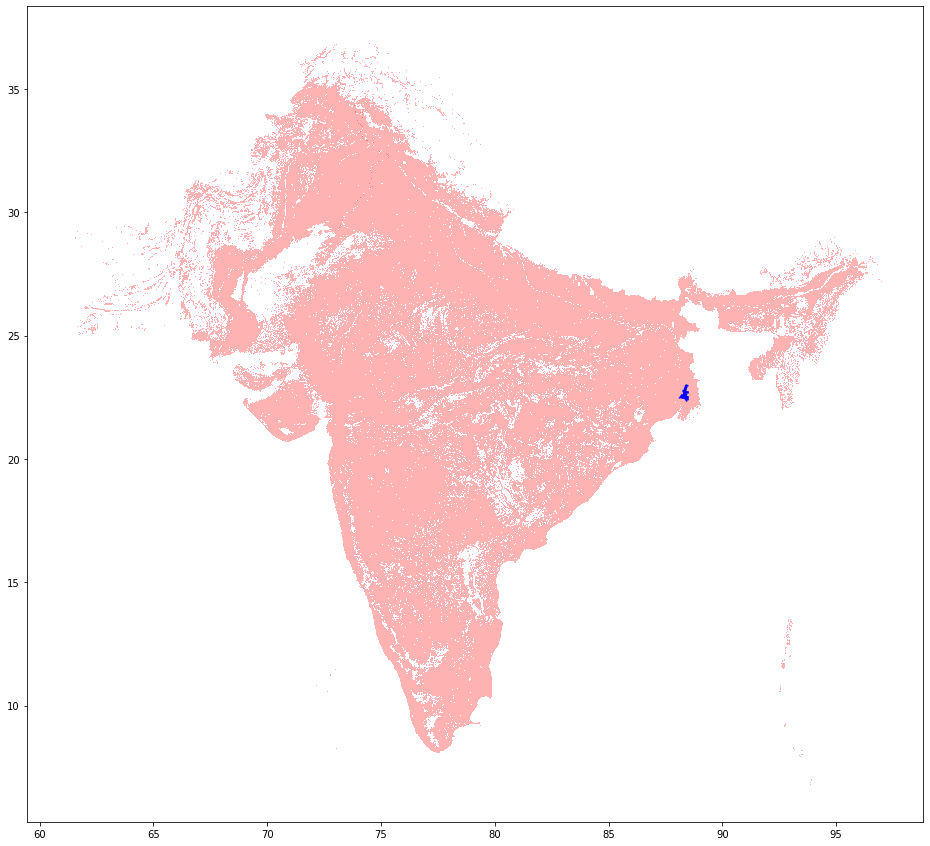

In [16]:
# plot country and aoi
base = gdf.plot(color = 'red', figsize = (20, 15), alpha = 0.3)
aoi.plot(ax = base, color = 'blue')

In [25]:
# add QuadKeys to gdf
gdf['quadkey'] = FB_QK 
gdf

,geometry,quadkey
0,"POLYGON ((73.65234 32.10119, 73.65234 32.08257...",12310322233000
1,"POLYGON ((73.74023 33.65121, 73.74023 33.63292...",12310320211300
2,"POLYGON ((63.06152 25.97780, 63.06152 25.95804...",12303300330332
3,"POLYGON ((70.37842 25.50278, 70.37842 25.48295...",12312212002233
4,"POLYGON ((69.25781 25.72074, 69.25781 25.70094...",12312203010200
...,...,...
594818,"POLYGON ((73.85010 29.42046, 73.85010 29.40132...",12312120100221
594819,"POLYGON ((80.46387 16.13026, 80.46387 16.10915...",12331201023110
594820,"POLYGON ((78.33252 24.54712, 78.33252 24.52714...",12312313323323
594821,"POLYGON ((82.46338 21.75950, 82.46338 21.73909...",12331010103003


In [19]:
FB_QKdata

,quadkey,latitude,longitude,rwi,error,quadkey1
0,12310322233000,32.091882,73.663330,0.101,0.490,12310322233000
1,12310320211300,33.642062,73.751221,-0.354,0.435,12310320211300
2,12303300330332,25.967922,63.072510,-0.251,0.396,12303300330332
3,12312212002233,25.492868,70.389404,-0.160,0.400,12312212002233
4,12312203010200,25.710836,69.268799,-0.690,0.421,12312203010200
...,...,...,...,...,...,...
594818,12312120100221,29.410890,73.861084,1.054,0.558,12312120100221
594819,12331201023110,16.119708,80.474853,-0.340,0.428,12331201023110
594820,12312313323323,24.537129,78.343506,-0.182,0.450,12312313323323
594821,12331010103003,21.749295,82.474365,-0.635,0.485,12331010103003


In [26]:
gdf.dtypes

geometry    geometry
quadkey       object
dtype: object

In [27]:
# change type of quadkey column to str
gdf["quadkey"] = gdf["quadkey"].astype('str')

In [28]:
# merge gdf and fb data
gdf = gdf.merge(FB_QKdata, left_on = 'quadkey', right_on = 'quadkey1', how = 'inner')

In [29]:
gdf[3003:3006]

,geometry,quadkey_x,quadkey_y,latitude,longitude,rwi,error,quadkey1
3003,"POLYGON ((70.46631 33.66950, 70.46631 33.65121...",12310230200133,12310230200133,33.660353,70.477295,-0.457,0.412,12310230200133
3004,"POLYGON ((71.45508 30.03105, 71.45508 30.01203...",12312012310320,12312012310320,30.021543,71.466065,-0.361,0.478,12312012310320
3005,"POLYGON ((70.40039 28.69059, 70.40039 28.67131...",12312030202300,12312030202300,28.680949,70.411377,0.391,0.479,12312030202300


<AxesSubplot:>

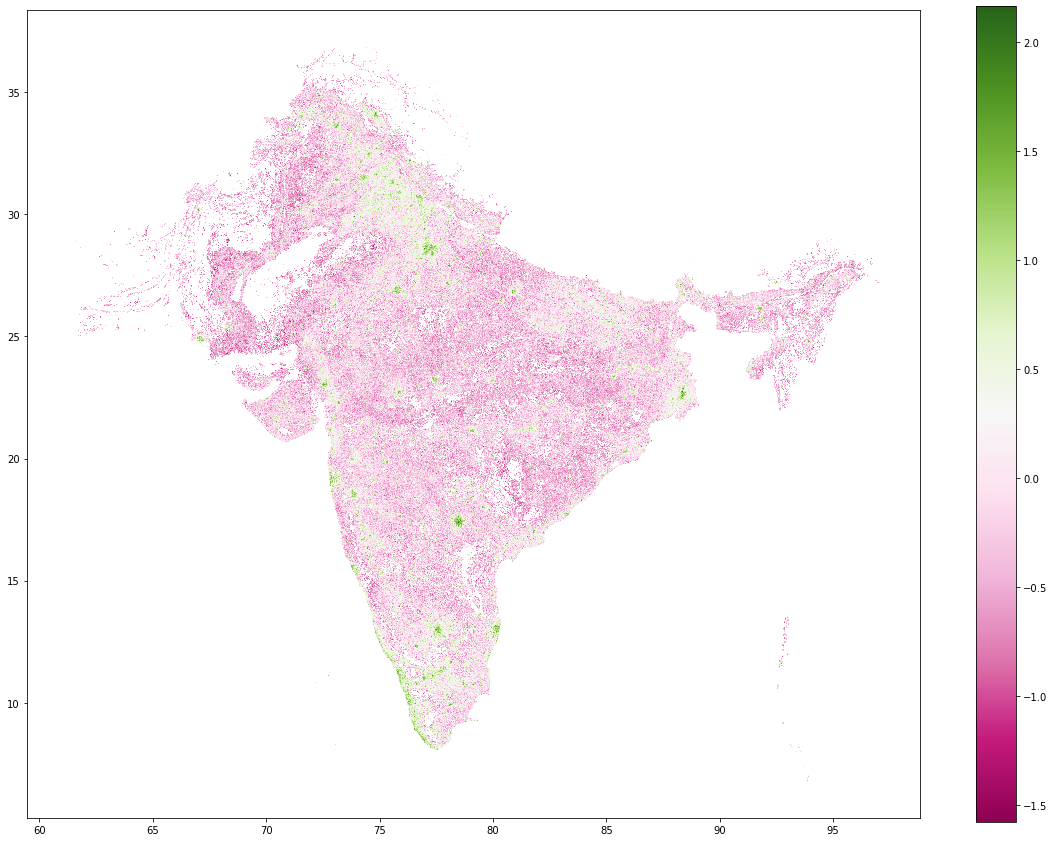

In [30]:
# plot choropleth map of RWI
gdf.plot(column = 'rwi', cmap = 'PiYG', figsize = (20, 15), legend = True)

<AxesSubplot:>

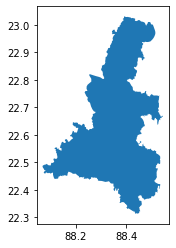

In [25]:
aoi.plot()

In [31]:
# export to shapefile
gdf.to_file("output/FB_QK_data_Kolkata.shp")

In [32]:
# produce summary stats
gdf.describe()

,quadkey_y,latitude,longitude,rwi,error
count,5.951690e+05,595169.000000,595169.000000,595169.000000,595169.000000
mean,1.235893e+13,23.620725,78.057545,-0.149118,0.469238
std,1.841681e+11,5.674553,5.851124,0.411387,0.049413
min,1.230303e+13,6.806444,61.248779,-1.578000,0.298000
25%,1.231220e+13,20.128155,74.058838,-0.441000,0.433000
50%,1.231322e+13,24.256981,77.244873,-0.212000,0.470000
75%,1.233031e+13,27.342494,81.353760,0.083000,0.504000
max,1.322203e+13,36.835668,97.020264,2.162000,0.694000
